In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Load your AIS data
df = pd.read_csv("AIS_datapoints_ClippedTo_LongIsland.csv")
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

# Group into vessel tracks and extract features
def extract_track_features(group):
    group = group.sort_values("BaseDateTime")
    start_lat, start_lon = group.iloc[0][["LAT", "LON"]]
    end_lat, end_lon = group.iloc[-1][["LAT", "LON"]]
    avg_cog = group["COG"].mean()
    avg_sog = group["SOG"].mean()
    duration = (group["BaseDateTime"].iloc[-1] - group["BaseDateTime"].iloc[0]).total_seconds() / 60.0
    return pd.Series({
        "start_lat": start_lat,
        "start_lon": start_lon,
        "end_lat": end_lat,
        "end_lon": end_lon,
        "avg_cog": avg_cog,
        "avg_sog": avg_sog,
        "duration_min": duration
    })

# Extract features
track_df = df.groupby("MMSI").apply(extract_track_features).reset_index()

C:\Users\Carson\AppData\Local\Temp\ipykernel_11492\925955622.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  track_df = df.groupby("MMSI").apply(extract_track_features).reset_index()


In [4]:
# Select features and scale
features = ["start_lat", "start_lon", "end_lat", "end_lon", "avg_cog", "avg_sog"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(track_df[features])

# Run K-means
k = 6  # You can change this to any number of clusters
kmeans = KMeans(n_clusters=k, random_state=123)
track_df["Cluster"] = kmeans.fit_predict(X_scaled)


In [5]:
# Merge cluster labels back to original AIS points by MMSI
df_clustered = df.merge(track_df[["MMSI", "Cluster"]], on="MMSI", how="inner")


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def plot_clustered_tracks_matplotlib(k=6):
    # Step 1: Run K-means on the track features
    features = ["start_lat", "start_lon", "end_lat", "end_lon", "avg_cog", "avg_sog"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(track_df[features])
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    track_df["Cluster"] = kmeans.fit_predict(X_scaled)

    # Step 2: Merge cluster labels with original AIS points
    df_clustered = df.merge(track_df[["MMSI", "Cluster"]], on="MMSI", how="inner")

    # Step 3: Plot using matplotlib
    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("tab10", n_colors=k)

    for cluster_id in range(k):
        cluster_data = df_clustered[df_clustered["Cluster"] == cluster_id]
        first = True  # control for single legend entry
        for mmsi, track in cluster_data.groupby("MMSI"):
            track = track.sort_values("BaseDateTime")
            if first:
                plt.plot(track["LON"], track["LAT"], color=palette[cluster_id], linewidth=1, label=f"Cluster {cluster_id}")
                first = False
            else:
                plt.plot(track["LON"], track["LAT"], color=palette[cluster_id], linewidth=1)

    plt.title(f"k-means, (k = {k})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title='Clusters', loc='best', prop={'size': 15})
    plt.tight_layout()
    plt.show()

# Add interactive slider
interact(plot_clustered_tracks_matplotlib, k=IntSlider(min=2, max=12, step=1, value=6, description='Clusters'))


interactive(children=(IntSlider(value=6, description='Clusters', max=12, min=2), Output()), _dom_classes=('wid…

<function __main__.plot_clustered_tracks_matplotlib(k=6)>

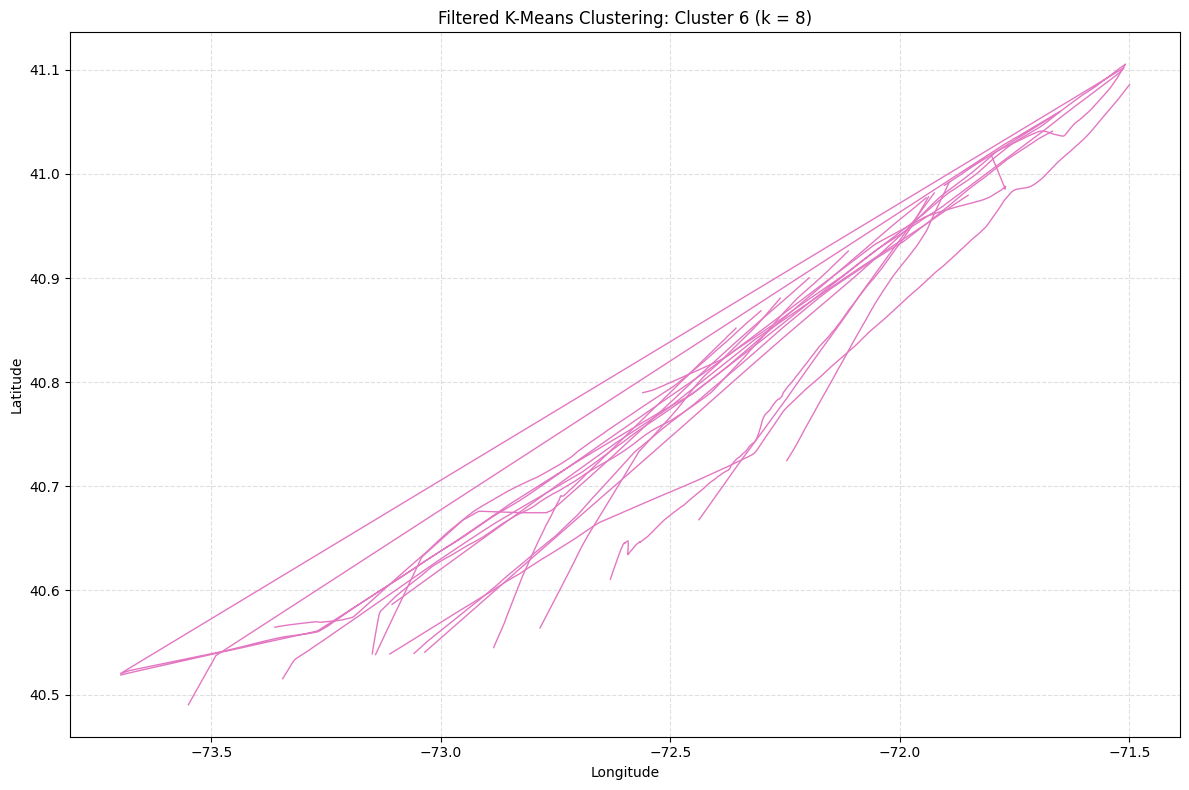

In [7]:
def plot_single_cluster(cluster_id=6, k=8):
    # Step 1: Run K-means
    features = ["start_lat", "start_lon", "end_lat", "end_lon", "avg_cog", "avg_sog"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(track_df[features])

    kmeans = KMeans(n_clusters=k, random_state=42)
    track_df["Cluster"] = kmeans.fit_predict(X_scaled)

    # Step 2: Merge clusters with AIS points
    df_clustered = df.merge(track_df[["MMSI", "Cluster"]], on="MMSI", how="inner")

    # Step 3: Filter only selected cluster
    cluster_data = df_clustered[df_clustered["Cluster"] == cluster_id]

    # Step 4: Plot
    plt.figure(figsize=(12, 8))
    color = sns.color_palette("tab10", n_colors=k)[cluster_id]

    for mmsi, track in cluster_data.groupby("MMSI"):
        track = track.sort_values("BaseDateTime")
        latitudes = track["LAT"].values
        longitudes = track["LON"].values

        plt.plot(
            longitudes, latitudes,
            label=f"Cluster {cluster_id}",
            color=color,
            linewidth=1
        )

    # Legend – only one label
    #plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot formatting
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Filtered K-Means Clustering: Cluster {cluster_id} (k = {k})")
    plt.tight_layout()
    plt.show()

# Run it
plot_single_cluster(cluster_id=6, k=8)


In [8]:
def count_tracks_in_cluster(cluster_id=6, k=8):
    # Step 1: Run K-means
    features = ["start_lat", "start_lon", "end_lat", "end_lon", "avg_cog", "avg_sog"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(track_df[features])

    kmeans = KMeans(n_clusters=k, random_state=42)
    track_df["Cluster"] = kmeans.fit_predict(X_scaled)

    # Step 2: Merge with AIS points
    df_clustered = df.merge(track_df[["MMSI", "Cluster"]], on="MMSI", how="inner")

    # Step 3: Count unique tracks
    total_tracks = track_df["MMSI"].nunique()
    cluster_tracks = track_df[track_df["Cluster"] == cluster_id]["MMSI"].nunique()

    print(f"Starting Tracks: {total_tracks}")
    print(f"Filtered Tracks: {cluster_tracks}")
    print(f"Percentage: {cluster_tracks / total_tracks:.2%}")

# Run it
count_tracks_in_cluster(cluster_id=6, k=8)


Starting Tracks: 136
Filtered Tracks: 16
Percentage: 11.76%
